# Navier-Stokes Equation
## A 2+1 Dimensional Numerical Experiment of FNOs

This notebook walks through the Fourier Neural Operator for a 2D problem such as the Navier-Stokes discussed in Section 5.3 in the paper [Fourier Neural Operator for
Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf) which uses a recurrent structure to propagates in time.

In [1]:
from typing import Any, Callable, Generic, NamedTuple, Optional, Tuple, TypeVar

import yaml
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer

from torch.nn.functional import mse_loss
import torch

from neuralop import count_params
from neuralop.datasets import load_navier_stokes_temporal_pt
from neuralop.layers import SpectralConv2d
from neuralop.models import FNO2d
from neuralop.training import LpLoss

torch.manual_seed(0)
np.random.seed(0)

In [2]:
#################################################
# Utilities
#################################################
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [3]:
################################################################
# fourier layer
################################################################
print(
"""
The overall network. It contains 4 layers of the Fourier layer.
1. Lift the input to the desire channel dimension by self.fc0 .
2. 4 layers of the integral operators u' = (W + K)(u).
    W defined by self.w; K defined by self.conv .
3. Project from the channel space to the output space by self.fc1 and self.fc2 .

input: the solution of the previous 10 timesteps + 2 locations
  (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
input shape: (batchsize, x=64, y=64, c=12)
output: the solution of the next timestep
output shape: (batchsize, x=64, y=64, c=1)
"""
)


The overall network. It contains 4 layers of the Fourier layer.
1. Lift the input to the desire channel dimension by self.fc0 .
2. 4 layers of the integral operators u' = (W + K)(u).
    W defined by self.w; K defined by self.conv .
3. Project from the channel space to the output space by self.fc1 and self.fc2 .

input: the solution of the previous 10 timesteps + 2 locations
  (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
input shape: (batchsize, x=64, y=64, c=12)
output: the solution of the next timestep
output shape: (batchsize, x=64, y=64, c=1)



In [4]:
class Config(NamedTuple):
    data_path: str
    n_train: int
    n_test: int
    train_batch_size: int
    test_batch_size: int
    learning_rate: float
    epochs: int
    iterations: int
    modes: int
    width: int
    subsampling_rate: int
    s: int
    history_length: int
    future_duration: int
    step: int
        
    @staticmethod
    def from_yaml(config_path: str):
        with open(config_path, 'r') as f:
            cfg = yaml.load(f)

        config = Config(
            data_path=cfg['data_path'],
            n_train=cfg['n_train'],
            n_test=cfg['n_test'],
            train_batch_size=cfg['train_batch_size'],
            test_batch_size=cfg['test_batch_size'],
            learning_rate=cfg['learning_rate'],
            epochs=cfg['epochs'],
            iterations=cfg['iterations'],
            modes=cfg['modes'],
            width=cfg['width'],
            subsampling_rate=cfg['subsampling_rate'],
            s=cfg['s'],
            history_length=cfg['history_length'],
            future_duration=cfg['future_duration'],
            step=cfg['step'],
        )        
        return config


config = Config.from_yaml('fourier_2d_time_V1e-5.yaml')

In [5]:
################################################################
# load data and data normalization
################################################################

train_loader, test_loader, output_encoder = load_navier_stokes_temporal_pt(
    config.data_path,
    config.n_train,
    config.n_test,
    config.history_length,
    config.future_duration,
    config.train_batch_size,
    config.test_batch_size,
)

UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [10, 64, 64].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [10, 64, 64].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05


In [6]:
model = FNO2d(
    config.modes,  # modes_width
    config.modes,  # modes_height
    config.width,  # width of all hidden layers
    # input channels are 12: the solution of the previous 10 timesteps + 2 location encodings
    # i.e: (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
    in_channels=2 + config.history_length,
    out_channels=1,  # output channel is 1: u(t, x, y)
    n_layers=4,
    # domain_padding=8,
    domain_padding=None,
    # domain_padding_mode='one-sided',
    use_mlp=True,
).cuda()
print(f"Model parameter count: {count_params(model):,d}")

Model parameter count: 239,773


In [7]:
################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.iterations
)
lp_loss = LpLoss()  # By default, does not do size averaging
output_encoder.cuda()

header_strings = (
    'Epoch',
    'Duration',
    'Training L2 (step)',
    'Training L2 (full)',
    'Testing L2 (step)',
    'Testing L2 (full)',
)
HEADER = ' | '.join(header_strings)
for ep in range(config.epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for train_data in train_loader:
        xx = train_data['x'].to(device)
        yy = train_data['y'].to(device)
        loss = 0

        # For each time step
        for t in range(0, config.future_duration, config.step):
            # We want the operator to learn the next S time steps:
            y = yy[:, t:t + config.step, ...]
            # use recurrent structure to propagate in time:
            im = model(xx)
            loss += lp_loss(
                im.reshape(config.train_batch_size, -1),
                y.reshape(config.train_batch_size, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), 1)

            # Advance the recurrent input by one time step; i.e:
            # [t_n, ..., t_{n+m}] --> [t_{n+s}, ..., t_{n+s+m}]
            # for starting time N, future duraiton M, and time step S
            xx = torch.cat((
                xx[..., config.step:-2, :, :],  # [t_{n+s}, ..., t_{n+m}]
                im,                             # [t_{n+m+1}, ..., t_{n+m+s}]
                xx[..., -2:, :, :]              # positional encoding
            ), dim=1)

        # Compare the full, operator-predicted future with the ground truth.
        # This is not used in training, but surfaces how well 
        # the operator has done overall in this epoch.
        train_l2_step += loss.item()
        l2_full = lp_loss(
            pred.reshape(config.train_batch_size, -1), 
            yy.reshape(config.train_batch_size, -1))
        train_l2_full += l2_full.item()

        # Backprop based only on the loss for each step-by-step in time.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    model.eval()
    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
        for test_data in test_loader:
            xx = test_data['x'].to(device)
            yy = test_data['y'].to(device)
            loss = 0

            for t in range(0, config.future_duration, config.step):
                y = yy[:, t:t + config.step, ...]
                im = model(xx)
                loss += lp_loss(
                    im.reshape(config.test_batch_size, -1), 
                    y.reshape(config.test_batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), 1)

                xx = torch.cat((
                    xx[..., config.step:-2, :, :],  # [t_{n+s}, ..., t_{n+m}]
                    im,                             # [t_{n+m+1}, ..., t_{n+m+s}]
                    xx[..., -2:, :, :]              # positional encoding
                ), dim=1)

            test_l2_step += loss.item()
            test_l2_full += lp_loss(
                pred.reshape(config.test_batch_size, -1), 
                yy.reshape(config.test_batch_size, -1)).item()

    t2 = default_timer()
    train_l2_step_normed = train_l2_step / config.n_train / (config.future_duration / config.step)
    train_l2_full_normed = train_l2_full / config.n_train
    test_l2_step_normed = test_l2_step / config.n_test / (config.future_duration / config.step)
    test_l2_full_normed = test_l2_full / config.n_test
    if ep % 20 == 0:
        print(HEADER)
    row = ' | '.join(
        [f'{ep:{len(header_strings[0])}d}', f'{t2 - t1:{len(header_strings[1])}.3f}'] + 
        [f'{x:{len(s)}.6f}' for s, x
         in zip(header_strings[2:], (train_l2_step_normed,
                                     train_l2_full_normed,
                                     test_l2_step_normed,
                                     test_l2_full_normed))])
    print(row)

Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
    0 |    7.641 |           0.732453 |           0.769933 |          0.621319 |          0.666341
    1 |    6.673 |           0.453760 |           0.499904 |          0.517793 |          0.550712
    2 |    6.525 |           0.376116 |           0.424743 |          0.457562 |          0.488969
    3 |    6.518 |           0.324060 |           0.367419 |          0.428035 |          0.456333
    4 |    7.095 |           0.287522 |           0.329927 |          0.416484 |          0.441045
    5 |    6.520 |           0.266275 |           0.307600 |          0.396948 |          0.418260
    6 |    6.509 |           0.248933 |           0.287863 |          0.401104 |          0.419303
    7 |    6.539 |           0.236605 |           0.274209 |          0.394046 |          0.412258
    8 |    7.152 |           0.228418 |           0.265294 |          0.389001 |          0.405481
    9 |   

   79 |    6.632 |           0.137739 |           0.160836 |          0.349522 |          0.358412
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
   80 |    7.263 |           0.137502 |           0.160546 |          0.347329 |          0.354600
   81 |    6.724 |           0.138028 |           0.161198 |          0.346666 |          0.353791
   82 |    7.387 |           0.136244 |           0.158882 |          0.348392 |          0.355911
   83 |    7.358 |           0.135540 |           0.157921 |          0.345699 |          0.352996
   84 |    7.334 |           0.137413 |           0.160750 |          0.344718 |          0.352127
   85 |    7.193 |           0.135240 |           0.157628 |          0.347330 |          0.354706
   86 |    6.567 |           0.134622 |           0.156852 |          0.346096 |          0.353621
   87 |    6.962 |           0.135143 |           0.157652 |          0.344300 |          0.351782
   88 |   

  158 |    7.300 |           0.120620 |           0.140412 |          0.345087 |          0.351480
  159 |    7.283 |           0.120848 |           0.140683 |          0.341991 |          0.348301
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
  160 |    7.195 |           0.124908 |           0.146728 |          0.343258 |          0.350811
  161 |    7.048 |           0.125265 |           0.147030 |          0.344129 |          0.351063
  162 |    6.323 |           0.122002 |           0.142404 |          0.341196 |          0.347210
  163 |    7.022 |           0.120601 |           0.140512 |          0.340089 |          0.346467
  164 |    7.337 |           0.120087 |           0.139742 |          0.340409 |          0.346501
  165 |    7.213 |           0.118776 |           0.137877 |          0.339454 |          0.345548
  166 |    6.533 |           0.119276 |           0.138656 |          0.342420 |          0.349121
  167 |   

  237 |    7.403 |           0.112974 |           0.131249 |          0.340123 |          0.345822
  238 |    7.478 |           0.112704 |           0.130809 |          0.340487 |          0.346080
  239 |    6.601 |           0.111602 |           0.129197 |          0.339692 |          0.345251
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
  240 |    6.683 |           0.111518 |           0.129119 |          0.340300 |          0.345757
  241 |    7.181 |           0.112082 |           0.129957 |          0.338928 |          0.344543
  242 |    7.094 |           0.112935 |           0.131196 |          0.338878 |          0.344587
  243 |    7.523 |           0.113649 |           0.132245 |          0.340933 |          0.346800
  244 |    7.486 |           0.112012 |           0.129900 |          0.339109 |          0.344350
  245 |    7.249 |           0.112154 |           0.130193 |          0.337648 |          0.343352
  246 |   

  316 |    7.527 |           0.107510 |           0.124333 |          0.338272 |          0.343523
  317 |    7.488 |           0.107490 |           0.124317 |          0.337256 |          0.342501
  318 |    7.119 |           0.107419 |           0.124231 |          0.337506 |          0.342735
  319 |    7.194 |           0.107299 |           0.124064 |          0.337286 |          0.342597
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
  320 |    6.703 |           0.107324 |           0.124123 |          0.337475 |          0.342628
  321 |    7.085 |           0.107202 |           0.123957 |          0.338154 |          0.343574
  322 |    7.143 |           0.107650 |           0.124599 |          0.338698 |          0.343997
  323 |    7.457 |           0.107107 |           0.123818 |          0.338005 |          0.343116
  324 |    7.562 |           0.107030 |           0.123692 |          0.338714 |          0.343807
  325 |   

  410 |    6.920 |           0.104463 |           0.120529 |          0.336827 |          0.341865
  411 |    7.374 |           0.104413 |           0.120454 |          0.336333 |          0.341324
  412 |    7.513 |           0.104361 |           0.120384 |          0.337040 |          0.342019
  413 |    7.381 |           0.104302 |           0.120300 |          0.336720 |          0.341677
  414 |    7.201 |           0.104307 |           0.120300 |          0.337466 |          0.342543
  415 |    7.134 |           0.104337 |           0.120361 |          0.336389 |          0.341372
  416 |    7.254 |           0.104256 |           0.120242 |          0.336901 |          0.341955
  417 |    6.628 |           0.104317 |           0.120341 |          0.337050 |          0.342131
  418 |    7.175 |           0.104242 |           0.120232 |          0.337379 |          0.342275
  419 |    7.065 |           0.104190 |           0.120154 |          0.336736 |          0.341749
Epoch | Du

  489 |    6.338 |           0.103674 |           0.119496 |          0.336799 |          0.341755
  490 |    7.188 |           0.103673 |           0.119495 |          0.336817 |          0.341774
  491 |    7.110 |           0.103671 |           0.119493 |          0.336816 |          0.341775
  492 |    7.004 |           0.103671 |           0.119492 |          0.336773 |          0.341734
  493 |    7.199 |           0.103670 |           0.119491 |          0.336808 |          0.341766
  494 |    7.176 |           0.103669 |           0.119488 |          0.336819 |          0.341777
  495 |    6.573 |           0.103668 |           0.119489 |          0.336807 |          0.341765
  496 |    7.026 |           0.103667 |           0.119488 |          0.336815 |          0.341772
  497 |    7.509 |           0.103667 |           0.119487 |          0.336808 |          0.341765
  498 |    7.190 |           0.103667 |           0.119486 |          0.336809 |          0.341767
  499 |   

In [8]:
class TB(NamedTuple):
    """Truth (& Beauty)"""
    index: int
    """Index of the source datapoint in the overall testing dataset."""
    truth: torch.Tensor
    beauty: torch.Tensor
    error: torch.Tensor


def sample_test_data(
    dataloader: torch.utils.data.DataLoader,
    index: int,
    sample_fn: Callable[[torch.Tensor], int],
) -> Tuple[int, torch.Tensor, torch.Tensor]:
    """Returns a sampled index from the ith batch of the loader."""
    found_idx = None
    for i, data in enumerate(dataloader):
        if i != index:
            continue
        
        xx = data['x'].to(device)
        yy = data['y'].to(device)
        for t in range(0, config.future_duration, config.step):
            im = model(xx)
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), 1)

            xx = torch.cat((
                xx[..., config.step:-2, :, :],  # [t_{n+s}, ..., t_{n+m}]
                im,                             # [t_{n+m+1}, ..., t_{n+m+s}]
                xx[..., -2:, :, :]              # positional encoding
            ), dim=1)
        
        error = (pred - yy).square()
        found_idx = sample_fn(error)
        return TB(found_idx, yy[found_idx], pred[found_idx], error[found_idx])

    return found_idx

## Visualization

Visualize the error in the trained model against a subsample of testing data points. Also visualize the error (squared to be non-negative).

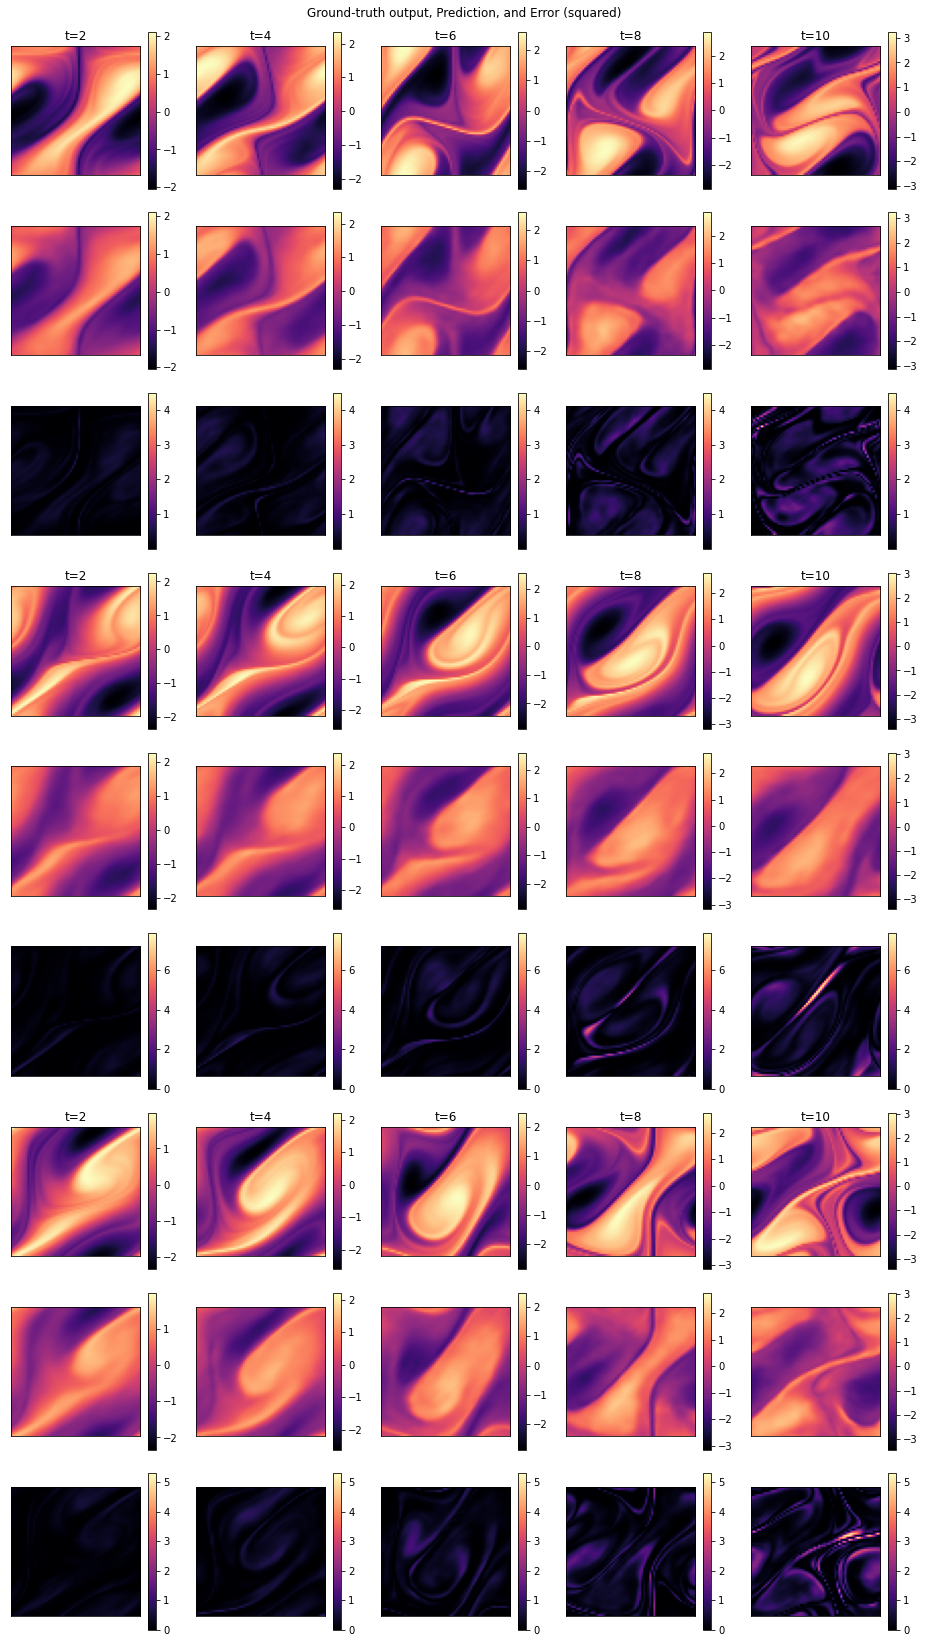

In [9]:
# test_samples = test_loader.dataset
n_samples = 3
n_rows = 3
n_cols = 5
t_step = 2

def sample_largest_error(error: torch.Tensor) -> int:
    m = [error[i].max() for i in range(error.shape[0])]
    mi = max(enumerate(m), key=lambda x: x[1])
    return mi[0]

fig = plt.figure(figsize=(13,   # width (inches)
                          23))  # height (inches)
for sample in range(n_samples):
    batch_number = 2 + 2 * sample
    _, yy, pred, error = sample_test_data(
        test_loader, batch_number, sample_largest_error)
    # pred *= 2
    # error = (pred - yy).square()

    vmin = [
        min(yy[i].min(), pred[i].min())
        for i in range(1, config.future_duration, t_step)
    ] 
    vmax = [
        max(yy[i].max(), pred[i].max())
        for i in range(1, config.future_duration, t_step)
    ] 

    # Ground truth:
    r = sample * n_rows
    for c in range(n_cols):
        t = (c + 1) * t_step - 1
        ax = fig.add_subplot(n_rows * n_samples, n_cols, r * n_cols + c + 1)
        im = ax.imshow(yy[t].cpu(),
                       cmap='magma', 
                       vmin=vmin[c], 
                       vmax=vmax[c])
        ax.set_title(f't={t + 1}')
        plt.xticks([], [])
        plt.yticks([], [])
        fig.colorbar(im, ax=ax)

    # Model prediction:
    r = sample * n_rows + 1
    for c in range(n_cols):
        t = (c + 1) * t_step - 1
        ax = fig.add_subplot(n_rows * n_samples, n_cols, r * n_cols + c + 1)
        im = ax.imshow(pred[t].detach().cpu(),
                       cmap='magma', 
                       vmin=vmin[c], 
                       vmax=vmax[c])
        plt.xticks([], [])
        plt.yticks([], [])
        fig.colorbar(im, ax=ax)

    # Error:
    r = sample * n_rows + 2
    for c in range(n_cols):
        t = (c + 1) * t_step - 1   
        ax = fig.add_subplot(n_rows * n_samples, n_cols, r * n_cols + c + 1)
        im = ax.imshow(error[t].detach().cpu(),
                       cmap='magma',
                       vmin=error.min(),
                       vmax=error.max())
        # print(f'{error[t].min():7.5f} <= error[t] <= {error[t].max():7.5f}')
        plt.xticks([], [])
        plt.yticks([], [])
        fig.colorbar(im, ax=ax)

fig.suptitle('Ground-truth output, Prediction, and Error (squared)', y=0.99)
plt.tight_layout()
fig.show()